# Deep Learning Methods For Finance


The objective of this work is to naively implement a simple recurrent neural network to solve a index prediction task. The index in question (aka the one we choose) is the SSMI.

As was advised in class, we did not start with a random model, but with a simple model frame we obtained from: https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233 (its hard to find an architecture who does not include dropout layers from the beginning) and https://www.kaggle.com/code/ozkanozturk/stock-price-prediction-by-simple-rnn-and-lstm. But this models took way to long and we wanted to just experiment a lot of options in the beginning, so we opted with a very simple one layer model (which is also used here https://towardsdatascience.com/a-practical-guide-to-rnn-and-lstm-in-keras-980f176271bc).  

The performance of this simple RNN will be compared against a model containing an LSTM layer. For each of these, there will be 9 different models who vary in epoch



## The problem

The problem is to predict the price of the SSMI index


## Loading the data

We will start by downloading the data from Kaggle:

In [1]:
import time
start_time = time.time()

In [2]:
import os
import pandas as pd
import warnings


In [3]:
df_project = pd.read_csv("indexProcessed.csv")
df_project['Close']=df_project['CloseUSD']
df_project.drop(['CloseUSD'], axis=1, inplace=True)
df_project = df_project.loc[df_project['Index'] == 'SSMI']
df_project.drop(['Index'], axis=1, inplace=True)
df = df_project.copy()
df.reset_index(inplace=True)
df.drop(['index'], axis=1, inplace=True)
df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-11-09,1378.900024,1389.000000,1375.300049,1539.680973,1387.099976,0.0
1,1990-11-12,1388.099976,1408.099976,1388.099976,1562.325000,1407.500000,0.0
2,1990-11-13,1412.199951,1429.400024,1411.400024,1570.871946,1415.199951,0.0
3,1990-11-14,1413.599976,1413.599976,1402.099976,1565.433054,1410.300049,0.0
4,1990-11-15,1410.599976,1416.699951,1405.099976,1560.326946,1405.699951,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7671 entries, 0 to 7670
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7671 non-null   object 
 1   Open       7671 non-null   float64
 2   High       7671 non-null   float64
 3   Low        7671 non-null   float64
 4   Close      7671 non-null   float64
 5   Adj Close  7671 non-null   float64
 6   Volume     7671 non-null   float64
dtypes: float64(6), object(1)
memory usage: 419.6+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7671.000000,7671.000000,7671.000000,7671.000000,7671.000000,7.671000e+03
mean,6410.012762,6448.342905,6369.483406,7114.803716,6409.733078,3.646631e+07
std,2441.470852,2451.869095,2429.404551,2709.188152,2440.710047,3.656943e+07
min,1288.699951,1296.599976,1279.000000,1429.235973,1287.599976,0.000000e+00
25%,5087.549805,5140.919921,5030.660157,5641.686108,5082.600098,0.000000e+00
50%,6647.520020,6686.899902,6607.850098,7380.501109,6649.100098,4.003240e+07
75%,8280.505371,8319.204590,8230.109863,9191.049858,8280.225097,5.785615e+07
max,11345.400390,11443.969730,11326.750000,12683.026933,11426.150390,3.467677e+08


## Data preprocessing

In [6]:
import numpy as np
import tensorflow as tf

# Set random seed for numpy:
np.random.seed(42)

# Set random seed for tensorFlow
tf.random.set_seed(24)

Let's now start by converting the `Date` variable to datetime:

In [7]:
df["Date"] = pd.to_datetime(df["Date"])

display(df.dtypes)
display(df[["Date"]].sample(5))

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume              float64
dtype: object

,Date
6456,2016-07-13
3333,2004-02-18
5728,2013-08-15
5391,2012-04-05
1731,1997-10-02


We can extract the year, month and day from the original `Date` variable:

In [8]:
df["Year"] = df["Date"].apply(lambda x : str(x)[:4])
df["Month"] = df["Date"].apply(lambda x : str(x)[5:7])
df["Day"] = df["Date"].apply(lambda x : str(x)[8:10])

df.sample(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
411,1992-07-07,1864.900024,1868.800049,1850.300049,2060.825973,1856.599976,0.0,1992,07,07
5076,2011-01-11,6454.390137,6542.640137,6451.109863,7253.672227,6534.839844,49082600.0,2011,01,11
2757,2001-10-30,6053.200195,6075.600098,5976.399902,6668.880000,6008.000000,0.0,2001,10,30


In [9]:
df.set_index("Date", inplace=True)
df.sample(5)

,Open,High,Low,Close,Adj Close,Volume,Year,Month,Day
Date,,,,,,,,,
2015-04-21,9317.059570,9357.419922,9299.429688,10322.366954,9299.429688,57290400.0,2015,04,21
2017-02-14,8459.099609,8461.509766,8420.250000,9353.026934,8426.150391,52930200.0,2017,02,14
1998-06-11,7651.600098,7651.899902,7489.600098,8323.223891,7498.399902,0.0,1998,06,11
2006-07-17,7504.799805,7529.799805,7428.100098,8326.442784,7501.299805,63444400.0,2006,07,17
1993-08-18,2464.500000,2489.699951,2463.600098,2760.791946,2487.199951,0.0,1993,08,18


### Splitting the data

In [10]:
# Imports 
import matplotlib.pyplot as plt

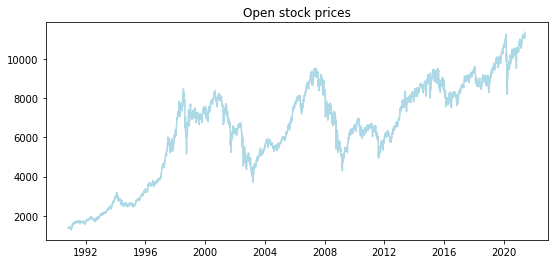

In [11]:
plt.figure(figsize=(9,4))
plt.plot(df["Open"], color="lightblue")
plt.title("Open stock prices")
plt.show()

How many days of data do we have in our dataset?

In [12]:
len(df)

7671

Let's try to predict the stock prices for the next 90 days.

In [13]:
open_prices = df[["Open"]].copy()
open_prices

,Open
Date,
1990-11-09,1378.900024
1990-11-12,1388.099976
1990-11-13,1412.199951
1990-11-14,1413.599976
1990-11-15,1410.599976
...,...
2021-05-20,11091.320310
2021-05-21,11205.809570
2021-05-26,11325.419920


In [14]:
open_prices.shape

(7671, 1)

Let's split the data into training, validation and test sets:
- Training: all the data except the last 270 days (roughly 9 months)
- Validation: 90 days right after the training set ends
- Test: 270 days after the testing ends

In [15]:
split_time = len(df)-270 

train = open_prices[:split_time]
test = open_prices[split_time:]

validation_split_time = 90
val = train[-validation_split_time:]
train = train[:-validation_split_time]

print(f"Shape of train data: {train.shape}")
print(f"Shape of val data: {val.shape}")
print(f"Shape of test data: {test.shape}")

Shape of train data: (7311, 1)
Shape of val data: (90, 1)
Shape of test data: (270, 1)


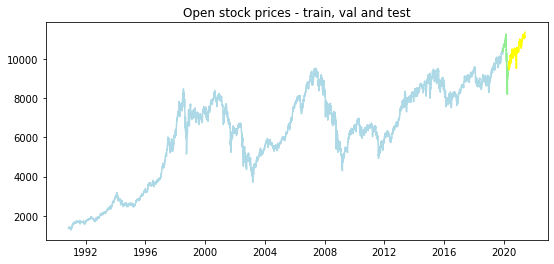

In [16]:
plt.figure(figsize=(9,4))
plt.plot(train, color="lightblue")
plt.plot(val, color="lightgreen")
plt.plot(test, color="yellow")
plt.title("Open stock prices - train, val and test")
plt.show()

### Standardize the data

In [17]:
# Imports:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

In [19]:
print(f"Shape of train: {train.shape}")
print(f"Shape of val: {val.shape}")
print(f"Shape of test: {test.shape}")

Shape of train: (7311, 1)
Shape of val: (90, 1)
Shape of test: (270, 1)


### Prepare data for training

In [20]:
# Imports:

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
timesteps = 30  # number of time steps to look back
batch_size = 32  # number of samples per batch

train_generator = TimeseriesGenerator(train, train, length=timesteps, batch_size=batch_size)
val_generator = TimeseriesGenerator(val, val, length=timesteps, batch_size=batch_size)
test_generator = TimeseriesGenerator(test, test, length=timesteps, batch_size=batch_size)

## Training And Evaluating The Models

### Simple RNN

#### Test 1

In [22]:
# Shared attributes:
loss_function = 'mse'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 50

num_samples, num_input_features = train.shape

In [23]:
# Define RNN's architecture here:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import SimpleRNN, Dense

rnn_model = Sequential()
rnn_model.add(SimpleRNN(units=128, input_shape=(num_input_features, 1), return_sequences=True))
rnn_model.add(Dense(1))

rnn_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
rnn_model.summary()

history_rnn_model = rnn_model.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 1, 128)            16640     
                                                                 
 dense (Dense)               (None, 1, 1)              129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\2091261247.py:12: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rnn_model = rnn_model.fit_generator(


Epoch 1/50
228/228 [==============================] - 3s 7ms/step - loss: 0.0051 - mae: 0.0414 - val_loss: 0.0110 - val_mae: 0.0790
Epoch 2/50
228/228 [==============================] - 1s 6ms/step - loss: 0.0013 - mae: 0.0258 - val_loss: 0.0106 - val_mae: 0.0872
Epoch 3/50
228/228 [==============================] - 1s 6ms/step - loss: 0.0013 - mae: 0.0263 - val_loss: 0.0126 - val_mae: 0.0798
Epoch 4/50
228/228 [==============================] - 1s 6ms/step - loss: 0.0011 - mae: 0.0232 - val_loss: 0.0107 - val_mae: 0.0826
Epoch 5/50
228/228 [==============================] - 1s 6ms/step - loss: 0.0012 - mae: 0.0249 - val_loss: 0.0107 - val_mae: 0.0813
Epoch 6/50
228/228 [==============================] - 1s 6ms/step - loss: 0.0010 - mae: 0.0225 - val_loss: 0.0105 - val_mae: 0.0811
Epoch 7/50
228/228 [==============================] - 1s 6ms/step - loss: 9.4395e-04 - mae: 0.0211 - val_loss: 0.0111 - val_mae: 0.0912
Epoch 8/50
228/228 [==============================] - 1s 6ms/step - loss

Here's an utility function that will allow us to collect and compare results:

In [24]:
def evaluate_model(model, model_name, train_gen, val_gen, test_gen, verbose=False):
    """Utility function that prints loss and MAE scores of a given model. Returns the results in a dataframe."""
    if verbose:
        print(f"Evaluation of {model_name}:")
    
    train_loss, train_mae = model.evaluate_generator(train_gen)
    val_loss, val_mae = model.evaluate_generator(val_gen)
    test_loss, test_mae = model.evaluate_generator(test_gen)
    
    if verbose:
        print(f"\nTest loss: {round(test_loss, 4)} \t | \ttest mae: {round(test_mae, 4)}")
        print(f"Val loss: {round(val_loss, 4)} \t | \tval mae: {round(val_mae, 4)}")
        print(f"Train loss: {round(train_loss, 4)} \t | \ttrain mae: {round(train_mae, 4)}")
        
    return pd.DataFrame.from_dict(
        [
            {
                "model_name": model_name,
                "test_loss": round(test_loss, 4),
                "test_mae": round(test_mae, 4),
                "val_loss": round(val_loss, 4),
                "val_mae": round(val_mae, 4),
                "train_loss": round(train_loss, 4),
                "train_mae": round(train_mae, 4)
            }
        ]
    )
    

In [25]:
results_rnn = evaluate_model(
    rnn_model,
    "RNN_MODEL1",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_rnn

Evaluation of RNN_MODEL1:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0011 	 | 	test mae: 0.0262
Val loss: 0.0115 	 | 	val mae: 0.0792
Train loss: 0.0008 	 | 	train mae: 0.0192


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL1,0.0011,0.0262,0.0115,0.0792,0.0008,0.0192


In [26]:
train_preds = rnn_model.predict(train)
val_preds = rnn_model.predict(val)
test_preds = rnn_model.predict(test)

print(f"Shape of train_preds: {train_preds.shape}")
print(f"Shape of val_preds: {val_preds.shape}")
print(f"Shape of test_preds: {test_preds.shape}")

9/9 [==============================] - 0s 1ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


In [27]:
# To correct the shapes (to plot the predictions) we need to apply the ravel function:
train_preds.ravel().shape

(7311,)

Checking what is inside a batch:

In [28]:
# The batch returns 2 arrays: features and targets
batch = train_generator[0]

lookback = len(batch[0][0])
num_days_being_predicted = len(batch[1][0])

print(f"The batch returns {len(batch)} arrays, corresponding to the X (features) and y (targets).")
print(f"The input sequences have length = {lookback}, meaning that our lookback is {lookback} days.")
print(f"Our target array has length = {num_days_being_predicted}, meaning that we are using the past {lookback} days to predict the next {num_days_being_predicted} day(s).")

The batch returns 2 arrays, corresponding to the X (features) and y (targets).
The input sequences have length = 30, meaning that our lookback is 30 days.
Our target array has length = 1, meaning that we are using the past 30 days to predict the next 1 day(s).


Let's now plot our predictions to compare with the true labels:

In [29]:
def plot_predictions(data_dict, indexes_dict, title, vars_to_plot=["train_preds", "val_preds", "test_preds", "train", "val", "test"]):
    # Note: this function assumes that data_d contains the info regarding true labels for train, val and test,
    # as well as predictions for train, val and test.
    color_code = {
        "train": "lightblue",
        "val": "lightgreen",
        "test": "yellow",
        "train_preds": "darkblue",
        "val_preds": "darkgreen",
        "test_preds": "orange"
    }
    
    plt.figure(figsize=(12,4))
    
    for col in vars_to_plot:
        plt.plot(indexes_dict[col], data_dict[col], color=color_code[col])
        
    
    plt.title(title)
    plt.show()

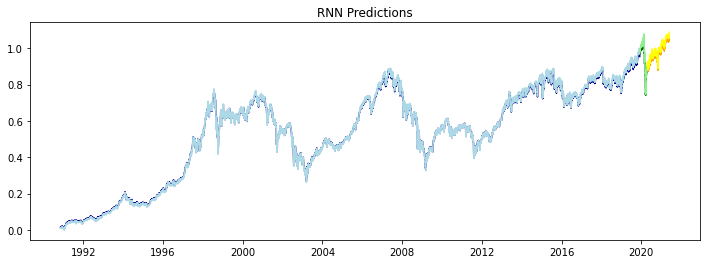

In [30]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds.ravel(), "val_preds": val_preds.ravel(), "test_preds": test_preds.ravel()
}

datetime_indexes = {
    "train": open_prices[:split_time-validation_split_time].index,
    "train_preds": open_prices[:split_time-validation_split_time].index,
    "val": open_prices[split_time-validation_split_time : split_time].index,
    "val_preds": open_prices[split_time-validation_split_time : split_time].index,
    "test": open_prices[split_time:].index,
    "test_preds": open_prices[split_time:].index
}

plot_predictions(data, datetime_indexes, "RNN Predictions")


#### Test 2

In [31]:
# Shared attributes:
loss_function = 'mse'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 20

num_samples, num_input_features = train.shape

In [32]:
# Define RNN's architecture here:
rnn_model2 = Sequential()
rnn_model2.add(SimpleRNN(units=128, input_shape=(num_input_features, 1), return_sequences=True))
rnn_model2.add(Dense(1))

rnn_model2.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
rnn_model2.summary()

history_rnn_model2 = rnn_model2.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)

rnn_model2.save('rnn_model2.h5')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 1, 128)            16640     
                                                                 
 dense_1 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1617963809.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rnn_model2 = rnn_model2.fit_generator(


228/228 [==============================] - 2s 7ms/step - loss: 0.0090 - mae: 0.0481 - val_loss: 0.0114 - val_mae: 0.0824
Epoch 2/20
228/228 [==============================] - 2s 7ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 0.0127 - val_mae: 0.1003
Epoch 3/20
228/228 [==============================] - 2s 7ms/step - loss: 0.0013 - mae: 0.0254 - val_loss: 0.0102 - val_mae: 0.0848
Epoch 4/20
228/228 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0239 - val_loss: 0.0119 - val_mae: 0.0793
Epoch 5/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0012 - mae: 0.0257 - val_loss: 0.0119 - val_mae: 0.0797
Epoch 6/20
228/228 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0250 - val_loss: 0.0124 - val_mae: 0.0794
Epoch 7/20
228/228 [==============================] - 2s 7ms/step - loss: 9.8007e-04 - mae: 0.0224 - val_loss: 0.0104 - val_mae: 0.0826
Epoch 8/20
228/228 [==============================] - 2s 7ms/step - loss: 0.0011 - 

Here's an utility function that will allow us to collect and compare results:

In [33]:
results_rnn2 = evaluate_model(
    rnn_model2,
    "RNN_MODEL2",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_rnn2

Evaluation of RNN_MODEL2:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0009 	 | 	test mae: 0.0226
Val loss: 0.0122 	 | 	val mae: 0.0794
Train loss: 0.0008 	 | 	train mae: 0.019


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL2,0.0009,0.0226,0.0122,0.0794,0.0008,0.019


In [34]:
train_preds2 = rnn_model2.predict(train)
val_preds2 = rnn_model2.predict(val)
test_preds2 = rnn_model2.predict(test)

print(f"Shape of train_preds: {train_preds2.shape}")
print(f"Shape of val_preds: {val_preds2.shape}")
print(f"Shape of test_preds: {test_preds2.shape}")

9/9 [==============================] - 0s 1ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


In [35]:
# To correct the shapes (to plot the predictions) we need to apply the ravel function:
train_preds2.ravel().shape

(7311,)

Checking what is inside a batch:

Let's now plot our predictions to compare with the true labels:

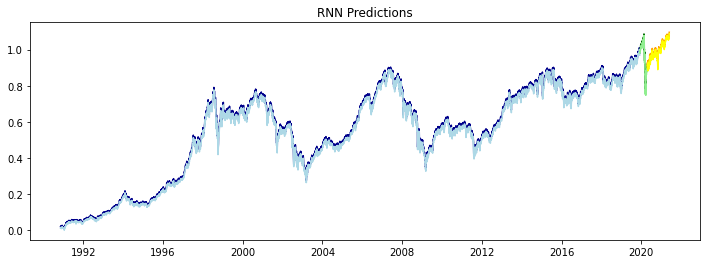

In [36]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds2.ravel(), "val_preds": val_preds2.ravel(), "test_preds": test_preds2.ravel()
}

datetime_indexes = {
    "train": open_prices[:split_time-validation_split_time].index,
    "train_preds": open_prices[:split_time-validation_split_time].index,
    "val": open_prices[split_time-validation_split_time : split_time].index,
    "val_preds": open_prices[split_time-validation_split_time : split_time].index,
    "test": open_prices[split_time:].index,
    "test_preds": open_prices[split_time:].index
}

plot_predictions(data, datetime_indexes, "RNN Predictions")


#### Test 3

In [37]:
# Shared attributes:
loss_function = 'mse'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 70

num_samples, num_input_features = train.shape

In [38]:
# Define RNN's architecture here:
rnn_model3 = Sequential()
rnn_model3.add(SimpleRNN(units=128, input_shape=(num_input_features, 1), return_sequences=True))
rnn_model3.add(Dense(1))

rnn_model3.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
rnn_model3.summary()

history_rnn_model3 = rnn_model3.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 1, 128)            16640     
                                                                 
 dense_2 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


Epoch 1/70


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\2645475868.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rnn_model3 = rnn_model3.fit_generator(


228/228 [==============================] - 2s 7ms/step - loss: 0.0188 - mae: 0.0661 - val_loss: 0.0187 - val_mae: 0.0907
Epoch 2/70
228/228 [==============================] - 1s 6ms/step - loss: 0.0024 - mae: 0.0307 - val_loss: 0.0113 - val_mae: 0.0870
Epoch 3/70
228/228 [==============================] - 1s 6ms/step - loss: 0.0016 - mae: 0.0258 - val_loss: 0.0131 - val_mae: 0.0807
Epoch 4/70
228/228 [==============================] - 1s 6ms/step - loss: 0.0016 - mae: 0.0278 - val_loss: 0.0105 - val_mae: 0.0835
Epoch 5/70
228/228 [==============================] - 1s 6ms/step - loss: 0.0012 - mae: 0.0233 - val_loss: 0.0133 - val_mae: 0.0806
Epoch 6/70
228/228 [==============================] - 1s 6ms/step - loss: 0.0011 - mae: 0.0239 - val_loss: 0.0148 - val_mae: 0.0830
Epoch 7/70
228/228 [==============================] - 1s 6ms/step - loss: 0.0011 - mae: 0.0233 - val_loss: 0.0116 - val_mae: 0.0790
Epoch 8/70
228/228 [==============================] - 1s 6ms/step - loss: 9.6914e-04 - 

Here's an utility function that will allow us to collect and compare results:

In [39]:
results_rnn3 = evaluate_model(
    rnn_model3,
    "RNN_MODEL3",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_rnn3

Evaluation of RNN_MODEL3:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0023 	 | 	test mae: 0.0419
Val loss: 0.0104 	 | 	val mae: 0.081
Train loss: 0.0009 	 | 	train mae: 0.0221


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL3,0.0023,0.0419,0.0104,0.081,0.0009,0.0221


In [40]:
train_preds3 = rnn_model3.predict(train)
val_preds3 = rnn_model3.predict(val)
test_preds3 = rnn_model3.predict(test)

print(f"Shape of train_preds: {train_preds3.shape}")
print(f"Shape of val_preds: {val_preds3.shape}")
print(f"Shape of test_preds: {test_preds3.shape}")

9/9 [==============================] - 0s 1ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


In [41]:
# To correct the shapes (to plot the predictions) we need to apply the ravel function:
train_preds3.ravel().shape

(7311,)

Checking what is inside a batch:

Let's now plot our predictions to compare with the true labels:

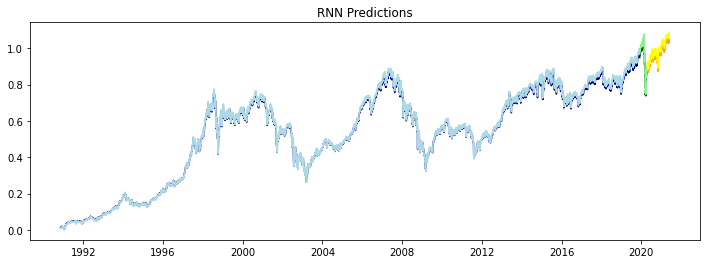

In [42]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds3.ravel(), "val_preds": val_preds3.ravel(), "test_preds": test_preds3.ravel()
}

datetime_indexes = {
    "train": open_prices[:split_time-validation_split_time].index,
    "train_preds": open_prices[:split_time-validation_split_time].index,
    "val": open_prices[split_time-validation_split_time : split_time].index,
    "val_preds": open_prices[split_time-validation_split_time : split_time].index,
    "test": open_prices[split_time:].index,
    "test_preds": open_prices[split_time:].index
}

plot_predictions(data, datetime_indexes, "RNN Predictions")


#### Test 4

In [43]:
# Shared attributes:
loss_function = 'mae'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 50

num_samples, num_input_features = train.shape

In [44]:
# Define RNN's architecture here:
rnn_model4 = Sequential()
rnn_model4.add(SimpleRNN(units=128, input_shape=(num_input_features, 1), return_sequences=True))
rnn_model4.add(Dense(1))

rnn_model4.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
rnn_model4.summary()

history_rnn_model4 = rnn_model4.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)

rnn_model4.save('rnn_model4.h5')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 1, 128)            16640     
                                                                 
 dense_3 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\2514207992.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rnn_model4 = rnn_model4.fit_generator(


228/228 [==============================] - 3s 8ms/step - loss: 0.0439 - mae: 0.0439 - val_loss: 0.0892 - val_mae: 0.0892
Epoch 2/50
228/228 [==============================] - 2s 10ms/step - loss: 0.0264 - mae: 0.0264 - val_loss: 0.0796 - val_mae: 0.0796
Epoch 3/50
228/228 [==============================] - 2s 10ms/step - loss: 0.0242 - mae: 0.0242 - val_loss: 0.0879 - val_mae: 0.0879
Epoch 4/50
228/228 [==============================] - 2s 10ms/step - loss: 0.0236 - mae: 0.0236 - val_loss: 0.0809 - val_mae: 0.0809
Epoch 5/50
228/228 [==============================] - 2s 8ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0799 - val_mae: 0.0799
Epoch 6/50
228/228 [==============================] - 1s 6ms/step - loss: 0.0252 - mae: 0.0252 - val_loss: 0.0799 - val_mae: 0.0799
Epoch 7/50
228/228 [==============================] - 1s 6ms/step - loss: 0.0223 - mae: 0.0223 - val_loss: 0.0794 - val_mae: 0.0794
Epoch 8/50
228/228 [==============================] - 2s 7ms/step - loss: 0.0221 - m

Here's an utility function that will allow us to collect and compare results:

In [45]:
results_rnn4 = evaluate_model(
    rnn_model4,
    "RNN_MODEL4",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_rnn4

Evaluation of RNN_MODEL4:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0351 	 | 	test mae: 0.0351
Val loss: 0.0809 	 | 	val mae: 0.0809
Train loss: 0.0204 	 | 	train mae: 0.0204


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL4,0.0351,0.0351,0.0809,0.0809,0.0204,0.0204


In [46]:
train_preds4 = rnn_model4.predict(train)
val_preds4 = rnn_model4.predict(val)
test_preds4 = rnn_model4.predict(test)

print(f"Shape of train_preds: {train_preds4.shape}")
print(f"Shape of val_preds: {val_preds4.shape}")
print(f"Shape of test_preds: {test_preds4.shape}")

9/9 [==============================] - 0s 1ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


In [47]:
# To correct the shapes (to plot the predictions) we need to apply the ravel function:
train_preds4.ravel().shape

(7311,)

Checking what is inside a batch:

Let's now plot our predictions to compare with the true labels:

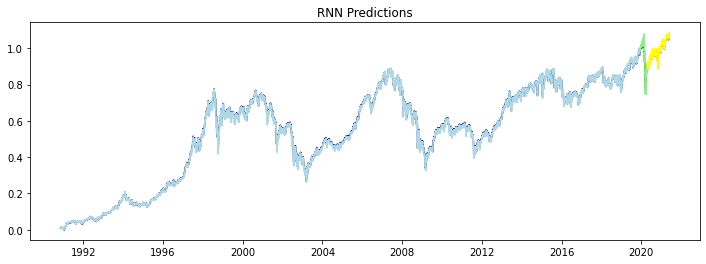

In [48]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds4.ravel(), "val_preds": val_preds4.ravel(), "test_preds": test_preds4.ravel()
}

datetime_indexes = {
    "train": open_prices[:split_time-validation_split_time].index,
    "train_preds": open_prices[:split_time-validation_split_time].index,
    "val": open_prices[split_time-validation_split_time : split_time].index,
    "val_preds": open_prices[split_time-validation_split_time : split_time].index,
    "test": open_prices[split_time:].index,
    "test_preds": open_prices[split_time:].index
}

plot_predictions(data, datetime_indexes, "RNN Predictions")


#### Test 5

In [49]:
# Shared attributes:
loss_function = 'mae'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 20

num_samples, num_input_features = train.shape

In [50]:
# Define RNN's architecture here:
rnn_model5 = Sequential()
rnn_model5.add(SimpleRNN(units=128, input_shape=(num_input_features, 1), return_sequences=True))
rnn_model5.add(Dense(1))

rnn_model5.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
rnn_model5.summary()

history_rnn_model5 = rnn_model5.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 1, 128)            16640     
                                                                 
 dense_4 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\2429787514.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rnn_model5 = rnn_model5.fit_generator(


228/228 [==============================] - 3s 7ms/step - loss: 0.0566 - mae: 0.0566 - val_loss: 0.1006 - val_mae: 0.1006
Epoch 2/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0276 - mae: 0.0276 - val_loss: 0.0804 - val_mae: 0.0804
Epoch 3/20
228/228 [==============================] - 2s 7ms/step - loss: 0.0273 - mae: 0.0273 - val_loss: 0.0828 - val_mae: 0.0828
Epoch 4/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0253 - mae: 0.0253 - val_loss: 0.1050 - val_mae: 0.1050
Epoch 5/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0806 - val_mae: 0.0806
Epoch 6/20
228/228 [==============================] - 2s 7ms/step - loss: 0.0230 - mae: 0.0230 - val_loss: 0.0816 - val_mae: 0.0816
Epoch 7/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0215 - mae: 0.0215 - val_loss: 0.0820 - val_mae: 0.0820
Epoch 8/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0216 - mae:

Here's an utility function that will allow us to collect and compare results:

In [51]:
results_rnn5 = evaluate_model(
    rnn_model5,
    "RNN_MODEL5",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_rnn5

Evaluation of RNN_MODEL5:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0209 	 | 	test mae: 0.0209
Val loss: 0.08 	 | 	val mae: 0.08
Train loss: 0.0191 	 | 	train mae: 0.0191


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL5,0.0209,0.0209,0.08,0.08,0.0191,0.0191


In [52]:
train_preds5 = rnn_model5.predict(train)
val_preds5 = rnn_model5.predict(val)
test_preds5 = rnn_model5.predict(test)

print(f"Shape of train_preds: {train_preds5.shape}")
print(f"Shape of val_preds: {val_preds5.shape}")
print(f"Shape of test_preds: {test_preds5.shape}")

9/9 [==============================] - 0s 1ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


In [53]:
# To correct the shapes (to plot the predictions) we need to apply the ravel function:
train_preds5.ravel().shape

(7311,)

Checking what is inside a batch:

Let's now plot our predictions to compare with the true labels:

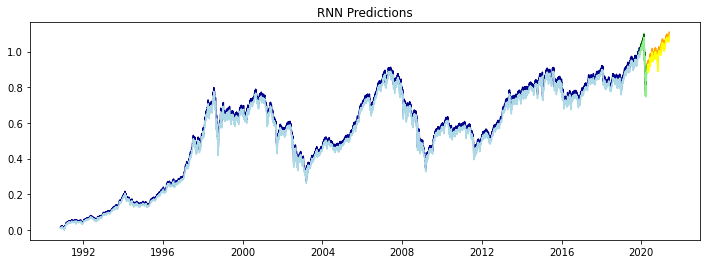

In [54]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds5.ravel(), "val_preds": val_preds5.ravel(), "test_preds": test_preds5.ravel()
}

datetime_indexes = {
    "train": open_prices[:split_time-validation_split_time].index,
    "train_preds": open_prices[:split_time-validation_split_time].index,
    "val": open_prices[split_time-validation_split_time : split_time].index,
    "val_preds": open_prices[split_time-validation_split_time : split_time].index,
    "test": open_prices[split_time:].index,
    "test_preds": open_prices[split_time:].index
}

plot_predictions(data, datetime_indexes, "RNN Predictions")


#### Test 6

In [55]:
# Shared attributes:
loss_function = 'mae'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 70

num_samples, num_input_features = train.shape

In [56]:
# Define RNN's architecture here:
rnn_model6 = Sequential()
rnn_model6.add(SimpleRNN(units=128, input_shape=(num_input_features, 1), return_sequences=True))
rnn_model6.add(Dense(1))

rnn_model6.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
rnn_model6.summary()

history_rnn_model6 = rnn_model6.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 1, 128)            16640     
                                                                 
 dense_5 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1149539611.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rnn_model6 = rnn_model6.fit_generator(


228/228 [==============================] - 2s 7ms/step - loss: 0.0718 - mae: 0.0718 - val_loss: 0.0980 - val_mae: 0.0980
Epoch 2/70
228/228 [==============================] - 1s 6ms/step - loss: 0.0328 - mae: 0.0328 - val_loss: 0.0833 - val_mae: 0.0833
Epoch 3/70
228/228 [==============================] - 1s 6ms/step - loss: 0.0243 - mae: 0.0243 - val_loss: 0.0801 - val_mae: 0.0801
Epoch 4/70
228/228 [==============================] - 2s 7ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0821 - val_mae: 0.0821
Epoch 5/70
228/228 [==============================] - 1s 6ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0806 - val_mae: 0.0806
Epoch 6/70
228/228 [==============================] - 2s 7ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0802 - val_mae: 0.0802
Epoch 7/70
228/228 [==============================] - 2s 7ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0830 - val_mae: 0.0830
Epoch 8/70
228/228 [==============================] - 1s 6ms/step - loss: 0.0240 - mae:

Here's an utility function that will allow us to collect and compare results:

In [57]:
results_rnn6 = evaluate_model(
    rnn_model6,
    "RNN_MODEL6",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_rnn6

Evaluation of RNN_MODEL6:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0239 	 | 	test mae: 0.0239
Val loss: 0.0793 	 | 	val mae: 0.0793
Train loss: 0.0192 	 | 	train mae: 0.0192


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL6,0.0239,0.0239,0.0793,0.0793,0.0192,0.0192


In [58]:
train_preds6 = rnn_model6.predict(train)
val_preds6 = rnn_model6.predict(val)
test_preds6 = rnn_model6.predict(test)

print(f"Shape of train_preds: {train_preds6.shape}")
print(f"Shape of val_preds: {val_preds6.shape}")
print(f"Shape of test_preds: {test_preds6.shape}")

9/9 [==============================] - 0s 1ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


In [59]:
# To correct the shapes (to plot the predictions) we need to apply the ravel function:
train_preds6.ravel().shape

(7311,)

Checking what is inside a batch:

Let's now plot our predictions to compare with the true labels:

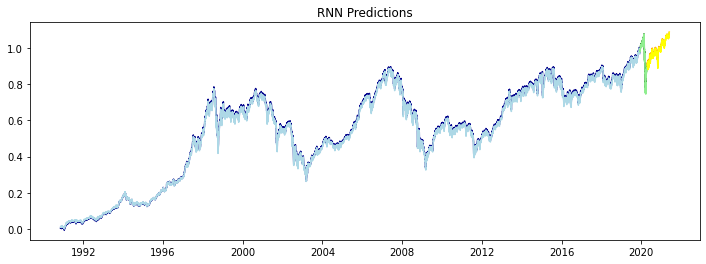

In [60]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds6.ravel(), "val_preds": val_preds6.ravel(), "test_preds": test_preds6.ravel()
}

datetime_indexes = {
    "train": open_prices[:split_time-validation_split_time].index,
    "train_preds": open_prices[:split_time-validation_split_time].index,
    "val": open_prices[split_time-validation_split_time : split_time].index,
    "val_preds": open_prices[split_time-validation_split_time : split_time].index,
    "test": open_prices[split_time:].index,
    "test_preds": open_prices[split_time:].index
}

plot_predictions(data, datetime_indexes, "RNN Predictions")


#### Test 7

In [61]:
# Shared attributes:
loss_function = 'mean_squared_error'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 50

num_samples, num_input_features = train.shape

In [62]:
# Define RNN's architecture here:
rnn_model7 = Sequential()
rnn_model7.add(SimpleRNN(units=128, input_shape=(num_input_features, 1), return_sequences=True))
rnn_model7.add(Dense(1))

rnn_model7.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
rnn_model7.summary()

history_rnn_model7 = rnn_model2.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_6 (SimpleRNN)    (None, 1, 128)            16640     
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 16,769
Trainable params: 16,769


Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
 20/228 [=>............................] - ETA: 1s - loss: 9.9723e-04 - mae: 0.0226

C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\3313969793.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rnn_model7 = rnn_model2.fit_generator(


228/228 [==============================] - 2s 8ms/step - loss: 0.0011 - mae: 0.0235 - val_loss: 0.0117 - val_mae: 0.0795
Epoch 2/50
228/228 [==============================] - 3s 11ms/step - loss: 0.0010 - mae: 0.0223 - val_loss: 0.0132 - val_mae: 0.0798
Epoch 3/50
228/228 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0230 - val_loss: 0.0110 - val_mae: 0.0803
Epoch 4/50
228/228 [==============================] - 1s 6ms/step - loss: 9.4503e-04 - mae: 0.0214 - val_loss: 0.0117 - val_mae: 0.0789
Epoch 5/50
228/228 [==============================] - 1s 6ms/step - loss: 9.4081e-04 - mae: 0.0215 - val_loss: 0.0106 - val_mae: 0.0877
Epoch 6/50
228/228 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0249 - val_loss: 0.0125 - val_mae: 0.0790
Epoch 7/50
228/228 [==============================] - 1s 6ms/step - loss: 9.5916e-04 - mae: 0.0221 - val_loss: 0.0112 - val_mae: 0.0787
Epoch 8/50
228/228 [==============================] - 1s 6ms/step - loss: 

Here's an utility function that will allow us to collect and compare results:

In [63]:
results_rnn7 = evaluate_model(
    rnn_model7,
    "RNN_MODEL7",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_rnn7

Evaluation of RNN_MODEL7:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)



Test loss: 0.4301 	 | 	test mae: 0.6438
Val loss: 0.3717 	 | 	val mae: 0.5875
Train loss: 0.1761 	 | 	train mae: 0.3746


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL7,0.4301,0.6438,0.3717,0.5875,0.1761,0.3746


In [64]:
train_preds7 = rnn_model7.predict(train)
val_preds7 = rnn_model7.predict(val)
test_preds7 = rnn_model7.predict(test)

print(f"Shape of train_preds: {train_preds7.shape}")
print(f"Shape of val_preds: {val_preds7.shape}")
print(f"Shape of test_preds: {test_preds7.shape}")

9/9 [==============================] - 0s 2ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


In [65]:
# To correct the shapes (to plot the predictions) we need to apply the ravel function:
train_preds7.ravel().shape

(7311,)

Checking what is inside a batch:

Let's now plot our predictions to compare with the true labels:

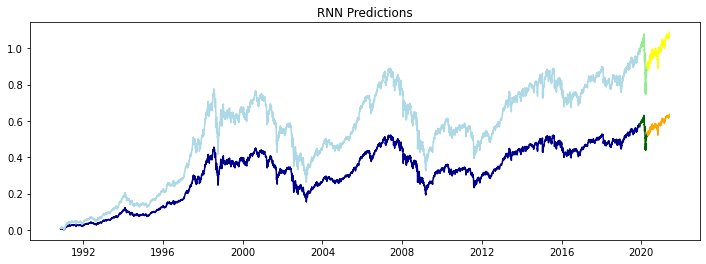

In [66]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds7.ravel(), "val_preds": val_preds7.ravel(), "test_preds": test_preds7.ravel()
}

datetime_indexes = {
    "train": open_prices[:split_time-validation_split_time].index,
    "train_preds": open_prices[:split_time-validation_split_time].index,
    "val": open_prices[split_time-validation_split_time : split_time].index,
    "val_preds": open_prices[split_time-validation_split_time : split_time].index,
    "test": open_prices[split_time:].index,
    "test_preds": open_prices[split_time:].index
}

plot_predictions(data, datetime_indexes, "RNN Predictions")


#### Test 8

In [67]:
# Shared attributes:
loss_function = 'mean_squared_error'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 20

num_samples, num_input_features = train.shape

In [68]:
# Define RNN's architecture here:
rnn_model8 = Sequential()
rnn_model8.add(SimpleRNN(units=128, input_shape=(num_input_features, 1), return_sequences=True))
rnn_model8.add(Dense(1))

rnn_model8.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
rnn_model8.summary()

history_rnn_model8 = rnn_model8.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 1, 128)            16640     
                                                                 
 dense_7 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1718980272.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rnn_model8 = rnn_model8.fit_generator(


228/228 [==============================] - 3s 7ms/step - loss: 0.0060 - mae: 0.0401 - val_loss: 0.0115 - val_mae: 0.0899
Epoch 2/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0012 - mae: 0.0244 - val_loss: 0.0113 - val_mae: 0.0814
Epoch 3/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0012 - mae: 0.0250 - val_loss: 0.0126 - val_mae: 0.0800
Epoch 4/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0011 - mae: 0.0234 - val_loss: 0.0151 - val_mae: 0.0844
Epoch 5/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0012 - mae: 0.0246 - val_loss: 0.0137 - val_mae: 0.0810
Epoch 6/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0012 - mae: 0.0249 - val_loss: 0.0139 - val_mae: 0.0819
Epoch 7/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0010 - mae: 0.0229 - val_loss: 0.0133 - val_mae: 0.0800
Epoch 8/20
228/228 [==============================] - 1s 6ms/step - loss: 0.0011 - mae:

Here's an utility function that will allow us to collect and compare results:

In [69]:
results_rnn8 = evaluate_model(
    rnn_model8,
    "RNN_MODEL8",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_rnn8

Evaluation of RNN_MODEL8:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0011 	 | 	test mae: 0.0252
Val loss: 0.0118 	 | 	val mae: 0.0797
Train loss: 0.0008 	 | 	train mae: 0.0195


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL8,0.0011,0.0252,0.0118,0.0797,0.0008,0.0195


In [70]:
train_preds8 = rnn_model8.predict(train)
val_preds8 = rnn_model8.predict(val)
test_preds8 = rnn_model8.predict(test)

print(f"Shape of train_preds: {train_preds8.shape}")
print(f"Shape of val_preds: {val_preds8.shape}")
print(f"Shape of test_preds: {test_preds8.shape}")

9/9 [==============================] - 0s 1000us/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


In [71]:
# To correct the shapes (to plot the predictions) we need to apply the ravel function:
train_preds8.ravel().shape

(7311,)

Checking what is inside a batch:

Let's now plot our predictions to compare with the true labels:

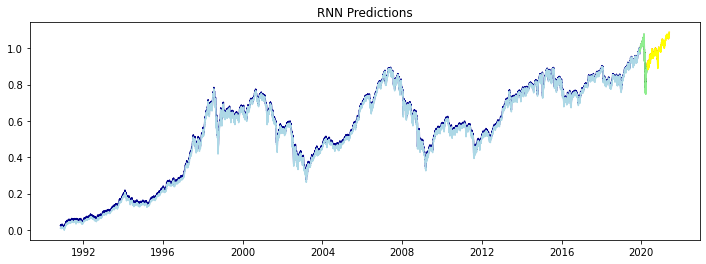

In [72]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds8.ravel(), "val_preds": val_preds8.ravel(), "test_preds": test_preds8.ravel()
}

datetime_indexes = {
    "train": open_prices[:split_time-validation_split_time].index,
    "train_preds": open_prices[:split_time-validation_split_time].index,
    "val": open_prices[split_time-validation_split_time : split_time].index,
    "val_preds": open_prices[split_time-validation_split_time : split_time].index,
    "test": open_prices[split_time:].index,
    "test_preds": open_prices[split_time:].index
}

plot_predictions(data, datetime_indexes, "RNN Predictions")


#### Test 9

In [73]:
# Shared attributes:
loss_function = 'mean_squared_error'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 70

num_samples, num_input_features = train.shape

In [74]:
# Define RNN's architecture here:
rnn_model9 = Sequential()
rnn_model9.add(SimpleRNN(units=128, input_shape=(num_input_features, 1), return_sequences=True))
rnn_model9.add(Dense(1))

rnn_model9.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
rnn_model9.summary()

history_rnn_model9 = rnn_model9.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_8 (SimpleRNN)    (None, 1, 128)            16640     
                                                                 
 dense_8 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/70


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\2677441085.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rnn_model9 = rnn_model9.fit_generator(


228/228 [==============================] - 3s 9ms/step - loss: 0.0085 - mae: 0.0486 - val_loss: 0.0110 - val_mae: 0.0824
Epoch 2/70
228/228 [==============================] - 2s 7ms/step - loss: 0.0017 - mae: 0.0301 - val_loss: 0.0121 - val_mae: 0.0791
Epoch 3/70
228/228 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0234 - val_loss: 0.0156 - val_mae: 0.0868
Epoch 4/70
228/228 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0231 - val_loss: 0.0123 - val_mae: 0.0789
Epoch 5/70
228/228 [==============================] - 1s 6ms/step - loss: 0.0012 - mae: 0.0243 - val_loss: 0.0109 - val_mae: 0.0839
Epoch 6/70
228/228 [==============================] - 1s 6ms/step - loss: 0.0012 - mae: 0.0248 - val_loss: 0.0232 - val_mae: 0.1158
Epoch 7/70
228/228 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0230 - val_loss: 0.0139 - val_mae: 0.0819
Epoch 8/70
228/228 [==============================] - 2s 7ms/step - loss: 0.0010 - mae:

Here's an utility function that will allow us to collect and compare results:

In [75]:
results_rnn9 = evaluate_model(
    rnn_model9,
    "RNN_MODEL9",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_rnn9

Evaluation of RNN_MODEL9:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0026 	 | 	test mae: 0.0455
Val loss: 0.0108 	 | 	val mae: 0.0831
Train loss: 0.0011 	 | 	train mae: 0.0254


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL9,0.0026,0.0455,0.0108,0.0831,0.0011,0.0254


In [76]:
train_preds9 = rnn_model9.predict(train)
val_preds9 = rnn_model9.predict(val)
test_preds9 = rnn_model9.predict(test)

print(f"Shape of train_preds: {train_preds9.shape}")
print(f"Shape of val_preds: {val_preds9.shape}")
print(f"Shape of test_preds: {test_preds9.shape}")

9/9 [==============================] - 0s 1ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


In [77]:
# To correct the shapes (to plot the predictions) we need to apply the ravel function:
train_preds9.ravel().shape

(7311,)

Checking what is inside a batch:

Let's now plot our predictions to compare with the true labels:

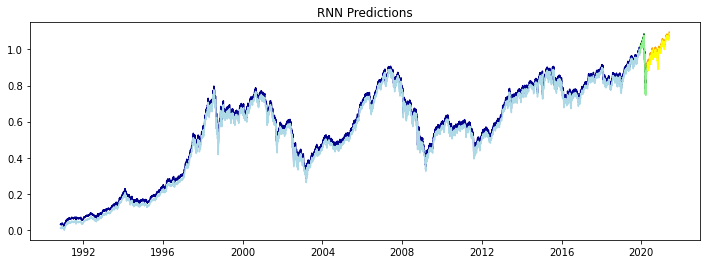

In [78]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds9.ravel(), "val_preds": val_preds9.ravel(), "test_preds": test_preds9.ravel()
}

datetime_indexes = {
    "train": open_prices[:split_time-validation_split_time].index,
    "train_preds": open_prices[:split_time-validation_split_time].index,
    "val": open_prices[split_time-validation_split_time : split_time].index,
    "val_preds": open_prices[split_time-validation_split_time : split_time].index,
    "test": open_prices[split_time:].index,
    "test_preds": open_prices[split_time:].index
}

plot_predictions(data, datetime_indexes, "RNN Predictions")


#### Results

In [79]:
results_rnn_all = pd.concat([results_rnn,
                             results_rnn2,
                             results_rnn3,
                             results_rnn4,
                             results_rnn5,
                             results_rnn6,
                             results_rnn7,
                             results_rnn8,
                             results_rnn9])
results_rnn_all

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL1,0.0011,0.0262,0.0115,0.0792,0.0008,0.0192
0,RNN_MODEL2,0.0009,0.0226,0.0122,0.0794,0.0008,0.0190
0,RNN_MODEL3,0.0023,0.0419,0.0104,0.0810,0.0009,0.0221
0,RNN_MODEL4,0.0351,0.0351,0.0809,0.0809,0.0204,0.0204
0,RNN_MODEL5,0.0209,0.0209,0.0800,0.0800,0.0191,0.0191
0,RNN_MODEL6,0.0239,0.0239,0.0793,0.0793,0.0192,0.0192
0,RNN_MODEL7,0.4301,0.6438,0.3717,0.5875,0.1761,0.3746
0,RNN_MODEL8,0.0011,0.0252,0.0118,0.0797,0.0008,0.0195
0,RNN_MODEL9,0.0026,0.0455,0.0108,0.0831,0.0011,0.0254


### LSTM

#### Early stopping

In [80]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    patience=10,
    monitor="val_loss",
    restore_best_weights=True
)

#### Test 1

In [81]:
# Shared attributes:
loss_function = 'mse'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 50

num_samples, num_input_features = train.shape

In [82]:
# Define LSTM's architecture here:
from tensorflow.keras.layers import LSTM

lstm_model = Sequential()
lstm_model.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model.add(Dense(1))

lstm_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            66560     
                                                                 
 dense_9 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [83]:
history_lstm_model = lstm_model.fit_generator( 
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs,
    callbacks=[early_stopping])

lstm_model.save('lstm_model.h5')

Epoch 1/50


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1374929510.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model = lstm_model.fit_generator(


228/228 [==============================] - 6s 19ms/step - loss: 0.0176 - mae: 0.0714 - val_loss: 0.0243 - val_mae: 0.1097
Epoch 2/50
228/228 [==============================] - 4s 17ms/step - loss: 0.0044 - mae: 0.0373 - val_loss: 0.0172 - val_mae: 0.0909
Epoch 3/50
228/228 [==============================] - 4s 17ms/step - loss: 0.0024 - mae: 0.0303 - val_loss: 0.0156 - val_mae: 0.0868
Epoch 4/50
228/228 [==============================] - 4s 18ms/step - loss: 0.0015 - mae: 0.0262 - val_loss: 0.0110 - val_mae: 0.0879
Epoch 5/50
228/228 [==============================] - 4s 17ms/step - loss: 0.0014 - mae: 0.0262 - val_loss: 0.0138 - val_mae: 0.0817
Epoch 6/50
228/228 [==============================] - 4s 17ms/step - loss: 0.0013 - mae: 0.0254 - val_loss: 0.0210 - val_mae: 0.1079
Epoch 7/50
228/228 [==============================] - 4s 17ms/step - loss: 0.0012 - mae: 0.0243 - val_loss: 0.0164 - val_mae: 0.0890
Epoch 8/50
228/228 [==============================] - 6s 27ms/step - loss: 0.001

In [84]:
results_lstm = evaluate_model(
    lstm_model,
    "LSTM_MODEL1",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_lstm

Evaluation of LSTM_MODEL1:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0021 	 | 	test mae: 0.0394
Val loss: 0.0108 	 | 	val mae: 0.0817
Train loss: 0.001 	 | 	train mae: 0.0239


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL1,0.0021,0.0394,0.0108,0.0817,0.001,0.0239


In [85]:
train_preds = lstm_model.predict(train)
val_preds = lstm_model.predict(val)
test_preds = lstm_model.predict(test)

print(f"Shape of train_preds: {train_preds.shape}")
print(f"Shape of val_preds: {val_preds.shape}")
print(f"Shape of test_preds: {test_preds.shape}")

9/9 [==============================] - 0s 1ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


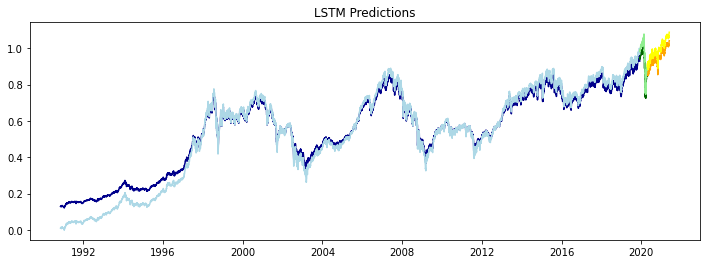

In [86]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds.ravel(), "val_preds": val_preds.ravel(), "test_preds": test_preds.ravel()
}

plot_predictions(data, datetime_indexes, "LSTM Predictions")

#### Test 2

In [87]:
# Shared attributes:
loss_function = 'mse'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 20

num_samples, num_input_features = train.shape

In [88]:
# Define LSTM's architecture here:
lstm_model2 = Sequential()
lstm_model2.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model2.add(Dense(1))

lstm_model2.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dense_10 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [89]:
history_lstm_model2 = lstm_model2.fit_generator( 
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs,
    callbacks=[early_stopping])

lstm_model2.save('lstm_model2.h5')

Epoch 1/20


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\2986742100.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model2 = lstm_model2.fit_generator(


228/228 [==============================] - 6s 19ms/step - loss: 0.0230 - mae: 0.0851 - val_loss: 0.0327 - val_mae: 0.1208
Epoch 2/20
228/228 [==============================] - 4s 17ms/step - loss: 0.0051 - mae: 0.0373 - val_loss: 0.0220 - val_mae: 0.1024
Epoch 3/20
228/228 [==============================] - 4s 18ms/step - loss: 0.0028 - mae: 0.0316 - val_loss: 0.0135 - val_mae: 0.0882
Epoch 4/20
228/228 [==============================] - 5s 20ms/step - loss: 0.0018 - mae: 0.0276 - val_loss: 0.0125 - val_mae: 0.0826
Epoch 5/20
228/228 [==============================] - 4s 19ms/step - loss: 0.0015 - mae: 0.0270 - val_loss: 0.0113 - val_mae: 0.0824
Epoch 6/20
228/228 [==============================] - 5s 23ms/step - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0132 - val_mae: 0.0808
Epoch 7/20
228/228 [==============================] - 4s 18ms/step - loss: 0.0012 - mae: 0.0241 - val_loss: 0.0116 - val_mae: 0.0800
Epoch 8/20
228/228 [==============================] - 5s 24ms/step - loss: 0.001

In [90]:
results_lstm2 = evaluate_model(
    lstm_model2,
    "LSTM_MODEL2",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_lstm2

Evaluation of LSTM_MODEL2:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0018 	 | 	test mae: 0.0354
Val loss: 0.011 	 | 	val mae: 0.0808
Train loss: 0.0009 	 | 	train mae: 0.0228


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL2,0.0018,0.0354,0.011,0.0808,0.0009,0.0228


In [91]:
train_preds2 = lstm_model2.predict(train)
val_preds2 = lstm_model2.predict(val)
test_preds2 = lstm_model2.predict(test)

print(f"Shape of train_preds: {train_preds2.shape}")
print(f"Shape of val_preds: {val_preds2.shape}")
print(f"Shape of test_preds: {test_preds2.shape}")

9/9 [==============================] - 0s 1ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


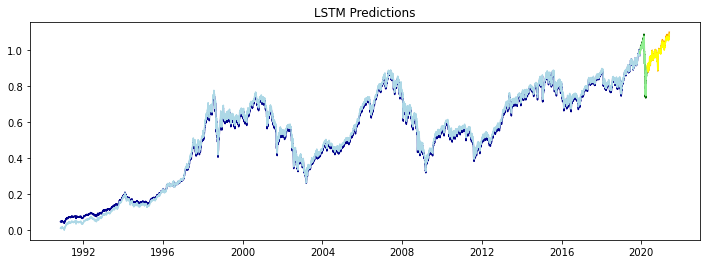

In [92]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds2.ravel(), "val_preds": val_preds2.ravel(), "test_preds": test_preds2.ravel()
}

plot_predictions(data, datetime_indexes, "LSTM Predictions")

#### Test 3

In [93]:
# Shared attributes:
loss_function = 'mse'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 70

num_samples, num_input_features = train.shape

In [94]:
# Define LSTM's architecture here:
lstm_model3 = Sequential()
lstm_model3.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model3.add(Dense(1))

lstm_model3.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dense_11 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [95]:
history_lstm_model3 = lstm_model3.fit_generator( 
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs,
    callbacks=[early_stopping])

lstm_model3.save('lstm_model3.h5')

Epoch 1/70


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\2000003166.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model3 = lstm_model3.fit_generator(


228/228 [==============================] - 6s 18ms/step - loss: 0.0218 - mae: 0.0802 - val_loss: 0.0281 - val_mae: 0.1083
Epoch 2/70
228/228 [==============================] - 4s 17ms/step - loss: 0.0051 - mae: 0.0388 - val_loss: 0.0194 - val_mae: 0.0942
Epoch 3/70
228/228 [==============================] - 4s 17ms/step - loss: 0.0029 - mae: 0.0318 - val_loss: 0.0153 - val_mae: 0.0874
Epoch 4/70
228/228 [==============================] - 4s 17ms/step - loss: 0.0018 - mae: 0.0262 - val_loss: 0.0127 - val_mae: 0.0841
Epoch 5/70
228/228 [==============================] - 4s 18ms/step - loss: 0.0015 - mae: 0.0259 - val_loss: 0.0120 - val_mae: 0.0824
Epoch 6/70
228/228 [==============================] - 4s 17ms/step - loss: 0.0014 - mae: 0.0254 - val_loss: 0.0112 - val_mae: 0.0822
Epoch 7/70
228/228 [==============================] - 4s 17ms/step - loss: 0.0013 - mae: 0.0248 - val_loss: 0.0125 - val_mae: 0.0803
Epoch 8/70
228/228 [==============================] - 5s 22ms/step - loss: 0.001

In [96]:
results_lstm3 = evaluate_model(
    lstm_model3,
    "LSTM_MODEL3",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_lstm3

Evaluation of LSTM_MODEL3:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)



Test loss: 0.0029 	 | 	test mae: 0.0486
Val loss: 0.0106 	 | 	val mae: 0.0835
Train loss: 0.0012 	 | 	train mae: 0.0272


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL3,0.0029,0.0486,0.0106,0.0835,0.0012,0.0272


In [97]:
train_preds3 = lstm_model3.predict(train)
val_preds3 = lstm_model3.predict(val)
test_preds3 = lstm_model3.predict(test)

print(f"Shape of train_preds: {train_preds3.shape}")
print(f"Shape of val_preds: {val_preds3.shape}")
print(f"Shape of test_preds: {test_preds3.shape}")

9/9 [==============================] - 0s 2ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


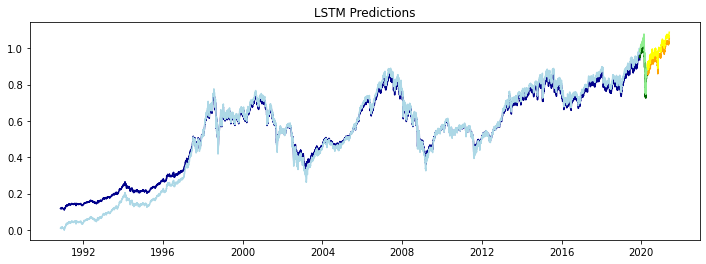

In [98]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds3.ravel(), "val_preds": val_preds3.ravel(), "test_preds": test_preds3.ravel()
}

plot_predictions(data, datetime_indexes, "LSTM Predictions")

#### Test 4

In [99]:
# Shared attributes:
loss_function = 'mae'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 50

num_samples, num_input_features = train.shape

In [100]:
# Define LSTM's architecture here:
lstm_model4 = Sequential()
lstm_model4.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model4.add(Dense(1))

lstm_model4.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model4.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dense_12 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [101]:
history_lstm_model4 = lstm_model4.fit_generator( 
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs,
    callbacks=[early_stopping])

lstm_model4.save('lstm_model4.h5')

Epoch 1/50


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\308010609.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model4 = lstm_model4.fit_generator(


228/228 [==============================] - 7s 24ms/step - loss: 0.0717 - mae: 0.0717 - val_loss: 0.1251 - val_mae: 0.1251
Epoch 2/50
228/228 [==============================] - 5s 21ms/step - loss: 0.0366 - mae: 0.0366 - val_loss: 0.0945 - val_mae: 0.0945
Epoch 3/50
228/228 [==============================] - 5s 22ms/step - loss: 0.0319 - mae: 0.0319 - val_loss: 0.0868 - val_mae: 0.0868
Epoch 4/50
228/228 [==============================] - 4s 19ms/step - loss: 0.0280 - mae: 0.0280 - val_loss: 0.0835 - val_mae: 0.0835
Epoch 5/50
228/228 [==============================] - 5s 21ms/step - loss: 0.0261 - mae: 0.0261 - val_loss: 0.0802 - val_mae: 0.0802
Epoch 6/50
228/228 [==============================] - 5s 20ms/step - loss: 0.0222 - mae: 0.0222 - val_loss: 0.0791 - val_mae: 0.0791
Epoch 7/50
228/228 [==============================] - 5s 23ms/step - loss: 0.0227 - mae: 0.0227 - val_loss: 0.0857 - val_mae: 0.0857
Epoch 8/50
228/228 [==============================] - 6s 28ms/step - loss: 0.022

In [102]:
results_lstm4 = evaluate_model(
    lstm_model4,
    "LSTM_MODEL4",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_lstm4

Evaluation of LSTM_MODEL4:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0235 	 | 	test mae: 0.0235
Val loss: 0.0791 	 | 	val mae: 0.0791
Train loss: 0.0203 	 | 	train mae: 0.0203


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL4,0.0235,0.0235,0.0791,0.0791,0.0203,0.0203


In [103]:
train_preds4 = lstm_model4.predict(train)
val_preds4 = lstm_model4.predict(val)
test_preds4 = lstm_model4.predict(test)

print(f"Shape of train_preds: {train_preds4.shape}")
print(f"Shape of val_preds: {val_preds4.shape}")
print(f"Shape of test_preds: {test_preds4.shape}")

9/9 [==============================] - 0s 3ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


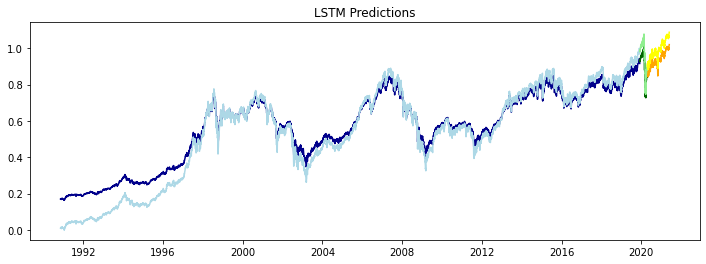

In [104]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds4.ravel(), "val_preds": val_preds4.ravel(), "test_preds": test_preds4.ravel()
}

plot_predictions(data, datetime_indexes, "LSTM Predictions")

#### Test 5

In [105]:
# Shared attributes:
loss_function = 'mae'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 20

num_samples, num_input_features = train.shape

In [106]:
# Define LSTM's architecture here:
lstm_model5 = Sequential()
lstm_model5.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model5.add(Dense(1))

lstm_model5.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model5.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dense_13 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [107]:
history_lstm_model5 = lstm_model5.fit_generator( 
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs,
    callbacks=[early_stopping])

lstm_model5.save('lstm_model5.h5')

Epoch 1/20


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\2615815181.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model5 = lstm_model5.fit_generator(


228/228 [==============================] - 6s 18ms/step - loss: 0.0686 - mae: 0.0686 - val_loss: 0.1075 - val_mae: 0.1075
Epoch 2/20
228/228 [==============================] - 4s 17ms/step - loss: 0.0362 - mae: 0.0362 - val_loss: 0.0936 - val_mae: 0.0936
Epoch 3/20
228/228 [==============================] - 4s 19ms/step - loss: 0.0314 - mae: 0.0314 - val_loss: 0.0906 - val_mae: 0.0906
Epoch 4/20
228/228 [==============================] - 4s 18ms/step - loss: 0.0262 - mae: 0.0262 - val_loss: 0.0815 - val_mae: 0.0815
Epoch 5/20
228/228 [==============================] - 4s 17ms/step - loss: 0.0237 - mae: 0.0237 - val_loss: 0.0795 - val_mae: 0.0795
Epoch 6/20
228/228 [==============================] - 4s 17ms/step - loss: 0.0219 - mae: 0.0219 - val_loss: 0.0826 - val_mae: 0.0826
Epoch 7/20
228/228 [==============================] - 4s 17ms/step - loss: 0.0260 - mae: 0.0260 - val_loss: 0.0836 - val_mae: 0.0836
Epoch 8/20
228/228 [==============================] - 4s 17ms/step - loss: 0.023

In [108]:
results_lstm5 = evaluate_model(
    lstm_model5,
    "LSTM_MODEL5",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_lstm5

Evaluation of LSTM_MODEL5:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0239 	 | 	test mae: 0.0239
Val loss: 0.0795 	 | 	val mae: 0.0795
Train loss: 0.0207 	 | 	train mae: 0.0207


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL5,0.0239,0.0239,0.0795,0.0795,0.0207,0.0207


In [109]:
train_preds5 = lstm_model5.predict(train)
val_preds5 = lstm_model5.predict(val)
test_preds5 = lstm_model5.predict(test)

print(f"Shape of train_preds: {train_preds5.shape}")
print(f"Shape of val_preds: {val_preds5.shape}")
print(f"Shape of test_preds: {test_preds5.shape}")

9/9 [==============================] - 0s 2ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


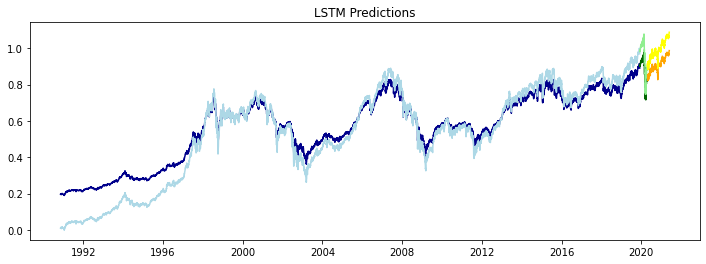

In [110]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds5.ravel(), "val_preds": val_preds5.ravel(), "test_preds": test_preds5.ravel()
}

plot_predictions(data, datetime_indexes, "LSTM Predictions")

#### Test 6

In [111]:
# Shared attributes:
loss_function = 'mae'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 70

num_samples, num_input_features = train.shape

In [112]:
# Define LSTM's architecture here:
lstm_model6 = Sequential()
lstm_model6.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model6.add(Dense(1))

lstm_model6.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model6.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dense_14 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [113]:
history_lstm_model6 = lstm_model6.fit_generator( 
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs,
    callbacks=[early_stopping])

lstm_model6.save('lstm_model6.h5')

Epoch 1/70


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\322467559.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model6 = lstm_model6.fit_generator(


228/228 [==============================] - 6s 18ms/step - loss: 0.0730 - mae: 0.0730 - val_loss: 0.1094 - val_mae: 0.1094
Epoch 2/70
228/228 [==============================] - 4s 17ms/step - loss: 0.0367 - mae: 0.0367 - val_loss: 0.0937 - val_mae: 0.0937
Epoch 3/70
228/228 [==============================] - 4s 17ms/step - loss: 0.0302 - mae: 0.0302 - val_loss: 0.0887 - val_mae: 0.0887
Epoch 4/70
228/228 [==============================] - 4s 17ms/step - loss: 0.0315 - mae: 0.0315 - val_loss: 0.0830 - val_mae: 0.0830
Epoch 5/70
228/228 [==============================] - 4s 17ms/step - loss: 0.0245 - mae: 0.0245 - val_loss: 0.0809 - val_mae: 0.0809
Epoch 6/70
228/228 [==============================] - 4s 17ms/step - loss: 0.0225 - mae: 0.0225 - val_loss: 0.0799 - val_mae: 0.0799
Epoch 7/70
228/228 [==============================] - 5s 21ms/step - loss: 0.0229 - mae: 0.0229 - val_loss: 0.0812 - val_mae: 0.0812
Epoch 8/70
228/228 [==============================] - 5s 20ms/step - loss: 0.025

In [114]:
results_lstm6 = evaluate_model(
    lstm_model6,
    "LSTM_MODEL6",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_lstm6

Evaluation of LSTM_MODEL6:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)



Test loss: 0.0231 	 | 	test mae: 0.0231
Val loss: 0.079 	 | 	val mae: 0.079
Train loss: 0.0202 	 | 	train mae: 0.0202


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL6,0.0231,0.0231,0.079,0.079,0.0202,0.0202


In [115]:
train_preds6 = lstm_model6.predict(train)
val_preds6 = lstm_model6.predict(val)
test_preds6 = lstm_model6.predict(test)

print(f"Shape of train_preds: {train_preds6.shape}")
print(f"Shape of val_preds: {val_preds6.shape}")
print(f"Shape of test_preds: {test_preds6.shape}")

9/9 [==============================] - 0s 2ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


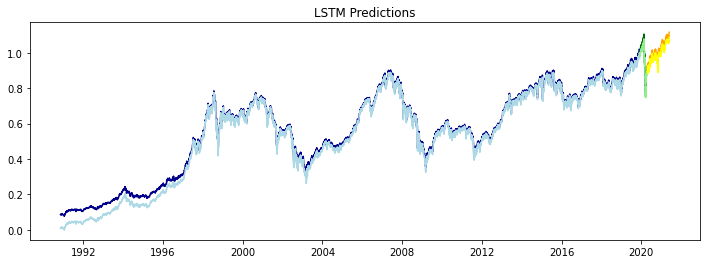

In [116]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds6.ravel(), "val_preds": val_preds6.ravel(), "test_preds": test_preds6.ravel()
}

plot_predictions(data, datetime_indexes, "LSTM Predictions")

#### Test 7

In [117]:
# Shared attributes:
loss_function = 'mean_squared_error'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 50

num_samples, num_input_features = train.shape

In [118]:
# Define LSTM's architecture here:
lstm_model7 = Sequential()
lstm_model7.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model7.add(Dense(1))

lstm_model7.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model7.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dense_15 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [119]:
history_lstm_model7 = lstm_model7.fit_generator( 
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs,
    callbacks=[early_stopping])

lstm_model7.save('lstm_model7.h5')

Epoch 1/50


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\3065704124.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model7 = lstm_model7.fit_generator(


228/228 [==============================] - 7s 21ms/step - loss: 0.0225 - mae: 0.0789 - val_loss: 0.0281 - val_mae: 0.1087
Epoch 2/50
228/228 [==============================] - 4s 19ms/step - loss: 0.0052 - mae: 0.0383 - val_loss: 0.0197 - val_mae: 0.0950
Epoch 3/50
228/228 [==============================] - 5s 21ms/step - loss: 0.0029 - mae: 0.0314 - val_loss: 0.0143 - val_mae: 0.0875
Epoch 4/50
228/228 [==============================] - 5s 21ms/step - loss: 0.0019 - mae: 0.0273 - val_loss: 0.0154 - val_mae: 0.0868
Epoch 5/50
228/228 [==============================] - 5s 20ms/step - loss: 0.0017 - mae: 0.0282 - val_loss: 0.0133 - val_mae: 0.0810
Epoch 6/50
228/228 [==============================] - 5s 20ms/step - loss: 0.0015 - mae: 0.0267 - val_loss: 0.0115 - val_mae: 0.0817
Epoch 7/50
228/228 [==============================] - 5s 21ms/step - loss: 0.0013 - mae: 0.0245 - val_loss: 0.0110 - val_mae: 0.0821
Epoch 8/50
228/228 [==============================] - 5s 20ms/step - loss: 0.001

In [120]:
results_lstm7 = evaluate_model(
    lstm_model7,
    "LSTM_MODEL7",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_lstm7

Evaluation of LSTM_MODEL7:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0045 	 | 	test mae: 0.0619
Val loss: 0.0106 	 | 	val mae: 0.0862
Train loss: 0.0015 	 | 	train mae: 0.03


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL7,0.0045,0.0619,0.0106,0.0862,0.0015,0.03


In [121]:
train_preds7 = lstm_model7.predict(train)
val_preds7 = lstm_model7.predict(val)
test_preds7 = lstm_model7.predict(test)

print(f"Shape of train_preds: {train_preds7.shape}")
print(f"Shape of val_preds: {val_preds7.shape}")
print(f"Shape of test_preds: {test_preds7.shape}")

9/9 [==============================] - 0s 1ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


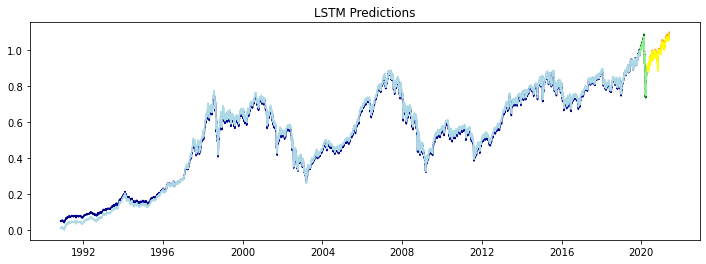

In [122]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds7.ravel(), "val_preds": val_preds7.ravel(), "test_preds": test_preds7.ravel()
}

plot_predictions(data, datetime_indexes, "LSTM Predictions")

#### Test 8

In [123]:
# Shared attributes:
loss_function = 'mean_squared_error'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 20

num_samples, num_input_features = train.shape

In [124]:
# Define LSTM's architecture here:
lstm_model8 = Sequential()
lstm_model8.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model8.add(Dense(1))

lstm_model8.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model8.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dense_16 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [125]:
history_lstm_model8 = lstm_model8.fit_generator( 
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs,
    callbacks=[early_stopping])

lstm_model8.save('lstm_model8.h5')

Epoch 1/20


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1758783459.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model8 = lstm_model8.fit_generator(


228/228 [==============================] - 6s 18ms/step - loss: 0.0201 - mae: 0.0784 - val_loss: 0.0266 - val_mae: 0.1054
Epoch 2/20
228/228 [==============================] - 4s 16ms/step - loss: 0.0046 - mae: 0.0361 - val_loss: 0.0192 - val_mae: 0.0940
Epoch 3/20
228/228 [==============================] - 4s 17ms/step - loss: 0.0025 - mae: 0.0304 - val_loss: 0.0131 - val_mae: 0.0867
Epoch 4/20
228/228 [==============================] - 4s 17ms/step - loss: 0.0018 - mae: 0.0275 - val_loss: 0.0141 - val_mae: 0.0831
Epoch 5/20
228/228 [==============================] - 4s 17ms/step - loss: 0.0016 - mae: 0.0274 - val_loss: 0.0153 - val_mae: 0.0858
Epoch 6/20
228/228 [==============================] - 4s 17ms/step - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0116 - val_mae: 0.0810
Epoch 7/20
228/228 [==============================] - 4s 17ms/step - loss: 0.0012 - mae: 0.0246 - val_loss: 0.0107 - val_mae: 0.0817
Epoch 8/20
228/228 [==============================] - 4s 17ms/step - loss: 0.001

In [126]:
results_lstm8 = evaluate_model(
    lstm_model8,
    "LSTM_MODEL8",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_lstm8

Evaluation of LSTM_MODEL8:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0026 	 | 	test mae: 0.0424
Val loss: 0.0107 	 | 	val mae: 0.0817
Train loss: 0.0011 	 | 	train mae: 0.0245


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL8,0.0026,0.0424,0.0107,0.0817,0.0011,0.0245


In [127]:
train_preds8 = lstm_model8.predict(train)
val_preds8 = lstm_model8.predict(val)
test_preds8 = lstm_model8.predict(test)

print(f"Shape of train_preds: {train_preds8.shape}")
print(f"Shape of val_preds: {val_preds8.shape}")
print(f"Shape of test_preds: {test_preds8.shape}")

9/9 [==============================] - 0s 3ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


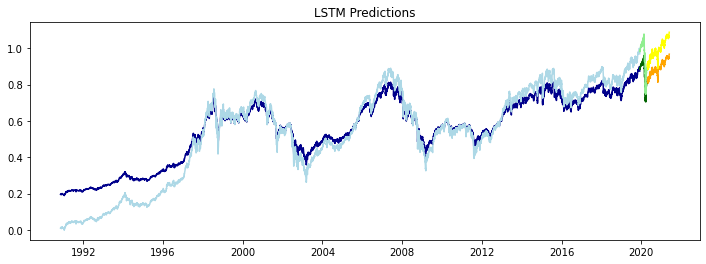

In [128]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds8.ravel(), "val_preds": val_preds8.ravel(), "test_preds": test_preds8.ravel()
}

plot_predictions(data, datetime_indexes, "LSTM Predictions")

#### Test 9

In [129]:
# Shared attributes:
loss_function = 'mean_squared_error'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 70

num_samples, num_input_features = train.shape

In [130]:
# Define LSTM's architecture here:
lstm_model9 = Sequential()
lstm_model9.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model9.add(Dense(1))

lstm_model9.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model9.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dense_17 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [131]:
history_lstm_model9 = lstm_model9.fit_generator( 
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs,
    callbacks=[early_stopping])

lstm_model9.save('lstm_model9.h5')

Epoch 1/70


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\3395444151.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model9 = lstm_model9.fit_generator(


228/228 [==============================] - 6s 20ms/step - loss: 0.0185 - mae: 0.0727 - val_loss: 0.0338 - val_mae: 0.1292
Epoch 2/70
228/228 [==============================] - 4s 19ms/step - loss: 0.0047 - mae: 0.0380 - val_loss: 0.0178 - val_mae: 0.0923
Epoch 3/70
228/228 [==============================] - 4s 19ms/step - loss: 0.0026 - mae: 0.0305 - val_loss: 0.0141 - val_mae: 0.0858
Epoch 4/70
228/228 [==============================] - 4s 17ms/step - loss: 0.0018 - mae: 0.0280 - val_loss: 0.0127 - val_mae: 0.0813
Epoch 5/70
228/228 [==============================] - 4s 18ms/step - loss: 0.0014 - mae: 0.0259 - val_loss: 0.0127 - val_mae: 0.0804
Epoch 6/70
228/228 [==============================] - 4s 17ms/step - loss: 0.0013 - mae: 0.0260 - val_loss: 0.0121 - val_mae: 0.0799
Epoch 7/70
228/228 [==============================] - 4s 16ms/step - loss: 0.0011 - mae: 0.0231 - val_loss: 0.0127 - val_mae: 0.0799
Epoch 8/70
228/228 [==============================] - 4s 17ms/step - loss: 0.001

In [132]:
results_lstm9 = evaluate_model(
    lstm_model9,
    "LSTM_MODEL9",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_lstm9

Evaluation of LSTM_MODEL9:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)



Test loss: 0.0031 	 | 	test mae: 0.0499
Val loss: 0.0105 	 | 	val mae: 0.0834
Train loss: 0.0012 	 | 	train mae: 0.0276


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL9,0.0031,0.0499,0.0105,0.0834,0.0012,0.0276


In [133]:
train_preds9 = lstm_model9.predict(train)
val_preds9 = lstm_model9.predict(val)
test_preds9 = lstm_model9.predict(test)

print(f"Shape of train_preds: {train_preds9.shape}")
print(f"Shape of val_preds: {val_preds9.shape}")
print(f"Shape of test_preds: {test_preds9.shape}")

9/9 [==============================] - 0s 1ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


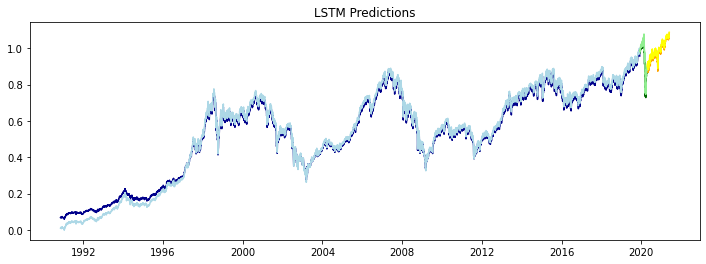

In [134]:
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds9.ravel(), "val_preds": val_preds9.ravel(), "test_preds": test_preds9.ravel()
}

plot_predictions(data, datetime_indexes, "LSTM Predictions")

#### Results

In [135]:
results_lstm_all = pd.concat([results_lstm,
                             results_lstm2,
                             results_lstm3,
                             results_lstm4,
                             results_lstm5,
                             results_lstm6,
                             results_lstm7,
                             results_lstm8,
                             results_lstm9])
results_lstm_all

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL1,0.0021,0.0394,0.0108,0.0817,0.0010,0.0239
0,LSTM_MODEL2,0.0018,0.0354,0.0110,0.0808,0.0009,0.0228
0,LSTM_MODEL3,0.0029,0.0486,0.0106,0.0835,0.0012,0.0272
0,LSTM_MODEL4,0.0235,0.0235,0.0791,0.0791,0.0203,0.0203
0,LSTM_MODEL5,0.0239,0.0239,0.0795,0.0795,0.0207,0.0207
0,LSTM_MODEL6,0.0231,0.0231,0.0790,0.0790,0.0202,0.0202
0,LSTM_MODEL7,0.0045,0.0619,0.0106,0.0862,0.0015,0.0300
0,LSTM_MODEL8,0.0026,0.0424,0.0107,0.0817,0.0011,0.0245
0,LSTM_MODEL9,0.0031,0.0499,0.0105,0.0834,0.0012,0.0276


#### RNN best model vs. LSTM best model

In [156]:
results = pd.concat([results_rnn2, results_lstm2])
results

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL2,0.0009,0.0226,0.0122,0.0794,0.0008,0.0190
0,LSTM_MODEL2,0.0018,0.0354,0.0110,0.0808,0.0009,0.0228


In [137]:
def plot_models_comparison(model_1_history, model_2_history, model_name_1, model_name_2, metric='mae'):
    val_metric = 'val_' + metric
        
    model_1_train_values = model_1_history.history[metric]
    model_1_val_values = model_1_history.history[val_metric]
    model_2_train_values = model_2_history.history[metric]
    model_2_val_values = model_2_history.history[val_metric]
        
    epochs = range(1, len(model_1_train_values) + 1)
        
    plt.figure(figsize=(10,4))
    plt.plot(epochs, model_1_train_values, color='lightblue', label=f'Training {metric}')
    plt.plot(epochs, model_1_val_values, color='pink', label=f'Validation {metric}')
    
    plt.title(f'{model_name_1} performance')
    plt.legend()
    
    plt.figure(figsize=(10,4))
    plt.plot(epochs, model_2_train_values, color='lightblue', label=f'Training {metric}')
    plt.plot(epochs, model_2_val_values, color='pink', label=f'Validation {metric}')
    
    plt.title(f'{model_name_2} performance')
    plt.legend()

**Note:** The irregularities in the validation curves can be explained by multiple factors, namely the size of the validation dataset (considerably small when compared to the training dataset, which may have a greater impact on the average mean squared error), as well as the different distribution and trend of the validation data. 

In [138]:
end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {int(total_time//60)} minutes and {int(total_time%60)} seconds")

Total time taken: 25 minutes and 34 seconds


# Working with the best models: trying the effect of dropout layers

In [139]:
from tensorflow.keras.layers import Dropout

In [140]:
def plot_models_comparison(model_1_history, model_2_history, model_name_1, model_name_2, metric='mae'):
    val_metric = 'val_' + metric
        
    model_1_train_values = model_1_history.history[metric]
    model_1_val_values = model_1_history.history[val_metric]
    model_2_train_values = model_2_history.history[metric]
    model_2_val_values = model_2_history.history[val_metric]
        
    epochs = range(1, len(model_1_train_values) + 1)
        
    plt.figure(figsize=(10,4))
    plt.plot(epochs, model_1_train_values, color='lightblue', label=f'Training {metric}')
    plt.plot(epochs, model_1_val_values, color='pink', label=f'Validation {metric}')
    
    plt.title(f'{model_name_1} performance')
    plt.legend()
    
    epochs = range(1, len(model_2_train_values) + 1)

    plt.figure(figsize=(10,4))
    plt.plot(epochs, model_2_train_values, color='lightblue', label=f'Training {metric}')
    plt.plot(epochs, model_2_val_values, color='pink', label=f'Validation {metric}')
    
    plt.title(f'{model_name_2} performance')
    plt.legend()

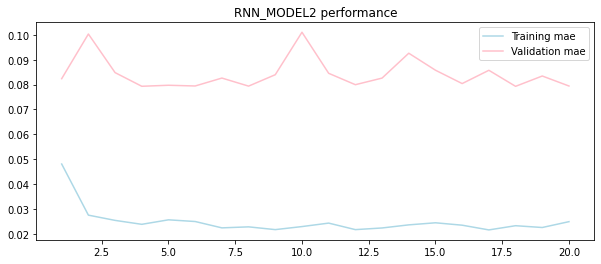

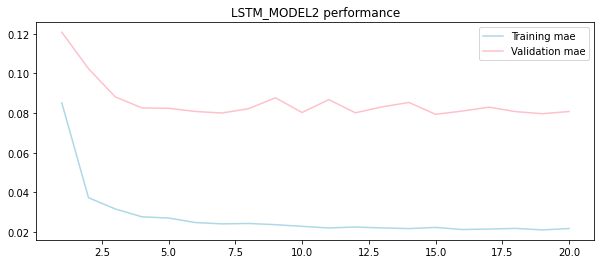

In [144]:
plot_models_comparison(history_rnn_model2, history_lstm_model2, "RNN_MODEL2", "LSTM_MODEL2")

### RNN

In [145]:
# Best model attributes (model 2)
loss_function = 'mse'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 20


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_10 (SimpleRNN)   (None, 1, 128)            16640     
                                                                 
 dropout_1 (Dropout)         (None, 1, 128)            0         
                                                                 
 dense_19 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 16,769
Trainable params: 16,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\4157078799.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_rnn_model_dropout = rnn_model_dropout.fit_generator(


228/228 [==============================] - 3s 9ms/step - loss: 0.0075 - mae: 0.0561 - val_loss: 0.0120 - val_mae: 0.0810
Epoch 2/20
228/228 [==============================] - 2s 8ms/step - loss: 0.0024 - mae: 0.0364 - val_loss: 0.0108 - val_mae: 0.0823
Epoch 3/20
228/228 [==============================] - 2s 9ms/step - loss: 0.0024 - mae: 0.0359 - val_loss: 0.0114 - val_mae: 0.0822
Epoch 4/20
228/228 [==============================] - 2s 7ms/step - loss: 0.0019 - mae: 0.0326 - val_loss: 0.0105 - val_mae: 0.0859
Epoch 5/20
228/228 [==============================] - 2s 7ms/step - loss: 0.0020 - mae: 0.0329 - val_loss: 0.0153 - val_mae: 0.0841
Epoch 6/20
228/228 [==============================] - 2s 9ms/step - loss: 0.0017 - mae: 0.0301 - val_loss: 0.0153 - val_mae: 0.0843
Epoch 7/20
228/228 [==============================] - 2s 8ms/step - loss: 0.0019 - mae: 0.0319 - val_loss: 0.0126 - val_mae: 0.0805
Epoch 8/20
228/228 [==============================] - 2s 7ms/step - loss: 0.0017 - mae:

C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)



Test loss: 0.0011 	 | 	test mae: 0.0253
Val loss: 0.0126 	 | 	val mae: 0.0816
Train loss: 0.0009 	 | 	train mae: 0.0204
9/9 [==============================] - 0s 2ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


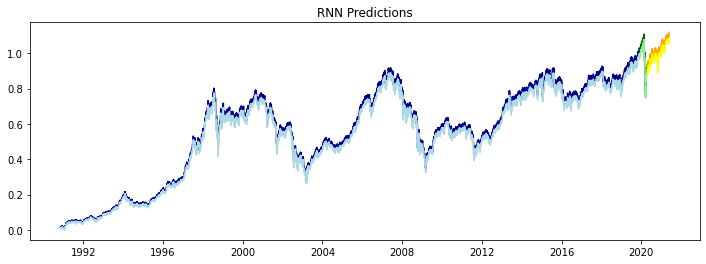

In [146]:
num_samples, num_input_features = train.shape
# Define RNN's architecture here:
rnn_model_dropout = Sequential()
rnn_model_dropout.add(SimpleRNN(units=128, input_shape=(num_input_features, 1), return_sequences=True))
rnn_model_dropout.add(Dropout(0.2))
rnn_model_dropout.add(Dense(1))

rnn_model_dropout.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
rnn_model_dropout.summary()

history_rnn_model_dropout = rnn_model_dropout.fit_generator(
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs
)

rnn_model_dropout.save('rnn_model_dropout.h5')
results_rnn_dropout = evaluate_model(
    rnn_model_dropout,
    "RNN_MODEL_DROPOUT",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_rnn_dropout

train_preds_dropout = rnn_model_dropout.predict(train)
val_preds_dropout = rnn_model_dropout.predict(val)
test_preds_dropout = rnn_model_dropout.predict(test)

print(f"Shape of train_preds: {train_preds_dropout.shape}")
print(f"Shape of val_preds: {val_preds_dropout.shape}")
print(f"Shape of test_preds: {test_preds_dropout.shape}")


data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds_dropout.ravel(), "val_preds": val_preds_dropout.ravel(), "test_preds": test_preds_dropout.ravel()
}

datetime_indexes = {
    "train": open_prices[:split_time-validation_split_time].index,
    "train_preds": open_prices[:split_time-validation_split_time].index,
    "val": open_prices[split_time-validation_split_time : split_time].index,
    "val_preds": open_prices[split_time-validation_split_time : split_time].index,
    "test": open_prices[split_time:].index,
    "test_preds": open_prices[split_time:].index
}

plot_predictions(data, datetime_indexes, "RNN Predictions")

In [157]:
results_rnn_dropout

,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,RNN_MODEL_DROPOUT,0.0011,0.0253,0.0126,0.0816,0.0009,0.0204


### LSTM

In [147]:
# Best model attributes (model 2)
loss_function = 'mse'  # other options: rmse, mae
optimizer = 'adam'  # other options: rmsprop, sgd, adagrad, adamax
metrics = ['mae']
epochs = 20


num_samples, num_input_features = train.shape

In [148]:
# Define LSTM's architecture here:
lstm_model_dropout = Sequential()
lstm_model_dropout.add(LSTM(units=128, input_shape=(num_input_features, 1), return_sequences=True))
lstm_model_dropout.add(Dropout(0.2))
lstm_model_dropout.add(Dense(1))

lstm_model_dropout.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
lstm_model_dropout.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 1, 128)            66560     
                                                                 
 dropout_2 (Dropout)         (None, 1, 128)            0         
                                                                 
 dense_20 (Dense)            (None, 1, 1)              129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [149]:
history_lstm_model_dropout = lstm_model_dropout.fit_generator( 
    train_generator, 
    validation_data=val_generator, 
    epochs=epochs,
    callbacks=[early_stopping])

lstm_model_dropout.save('lstm_model_dropout.h5')

Epoch 1/20


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\4096131102.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_lstm_model_dropout = lstm_model_dropout.fit_generator(


228/228 [==============================] - 7s 21ms/step - loss: 0.0230 - mae: 0.0876 - val_loss: 0.0321 - val_mae: 0.1167
Epoch 2/20
228/228 [==============================] - 4s 19ms/step - loss: 0.0058 - mae: 0.0455 - val_loss: 0.0235 - val_mae: 0.1072
Epoch 3/20
228/228 [==============================] - 4s 18ms/step - loss: 0.0036 - mae: 0.0397 - val_loss: 0.0151 - val_mae: 0.0870
Epoch 4/20
228/228 [==============================] - 4s 17ms/step - loss: 0.0025 - mae: 0.0346 - val_loss: 0.0114 - val_mae: 0.0869
Epoch 5/20
228/228 [==============================] - 4s 18ms/step - loss: 0.0022 - mae: 0.0335 - val_loss: 0.0111 - val_mae: 0.0857
Epoch 6/20
228/228 [==============================] - 5s 21ms/step - loss: 0.0020 - mae: 0.0328 - val_loss: 0.0140 - val_mae: 0.0822
Epoch 7/20
228/228 [==============================] - 5s 22ms/step - loss: 0.0018 - mae: 0.0311 - val_loss: 0.0141 - val_mae: 0.0820
Epoch 8/20
228/228 [==============================] - 5s 21ms/step - loss: 0.001

In [150]:
results_lstm_model_dropout = evaluate_model(
    lstm_model_dropout,
    "LSTM_MODEL_DROPOUT",
    train_generator,
    val_generator,
    test_generator,
    verbose=True 
)

results_lstm_model_dropout

Evaluation of LSTM_MODEL_DROPOUT:


C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  train_loss, train_mae = model.evaluate_generator(train_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  val_loss, val_mae = model.evaluate_generator(val_gen)
C:\Users\Joao\AppData\Local\Temp\ipykernel_22972\1209038209.py:8: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_loss, test_mae = model.evaluate_generator(test_gen)



Test loss: 0.0007 	 | 	test mae: 0.0202
Val loss: 0.0136 	 | 	val mae: 0.0801
Train loss: 0.001 	 | 	train mae: 0.0227


,model_name,test_loss,test_mae,val_loss,val_mae,train_loss,train_mae
0,LSTM_MODEL_DROPOUT,0.0007,0.0202,0.0136,0.0801,0.001,0.0227


9/9 [==============================] - 0s 2ms/step
Shape of train_preds: (7311, 1, 1)
Shape of val_preds: (90, 1, 1)
Shape of test_preds: (270, 1, 1)


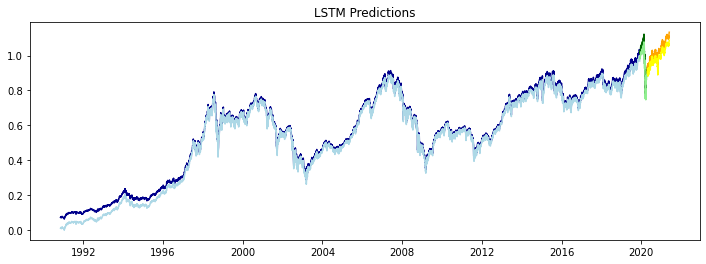

In [151]:
train_preds_dropout = lstm_model_dropout.predict(train)
val_preds_dropout = lstm_model_dropout.predict(val)
test_preds_dropout = lstm_model_dropout.predict(test)

print(f"Shape of train_preds: {train_preds_dropout.shape}")
print(f"Shape of val_preds: {val_preds_dropout.shape}")
print(f"Shape of test_preds: {test_preds_dropout.shape}")
data = {
    "train": train, "val": val, "test": test, 
    "train_preds": train_preds_dropout.ravel(), "val_preds": val_preds_dropout.ravel(), "test_preds": test_preds_dropout.ravel()
}

plot_predictions(data, datetime_indexes, "LSTM Predictions")

### Without Dropout vs With Dropout

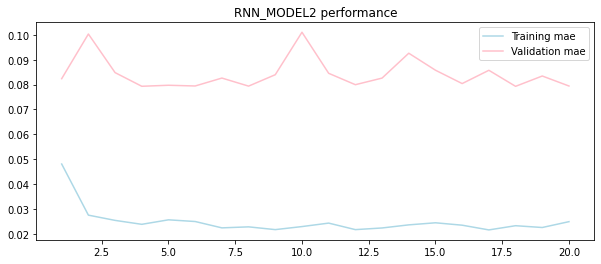

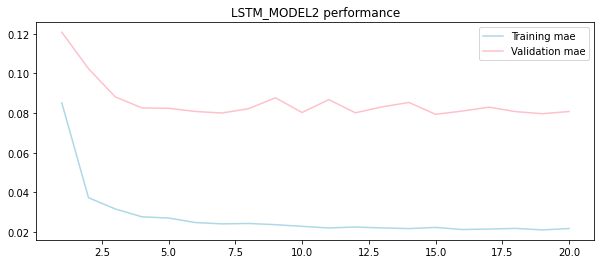

In [154]:
plot_models_comparison(history_rnn_model2, history_lstm_model2, "RNN_MODEL2", "LSTM_MODEL2")

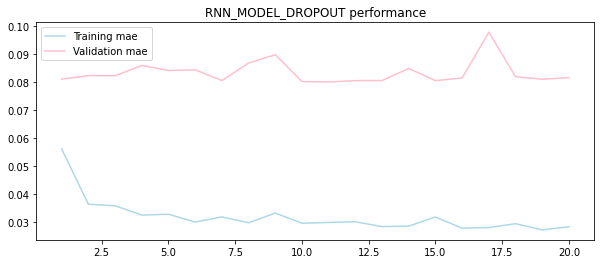

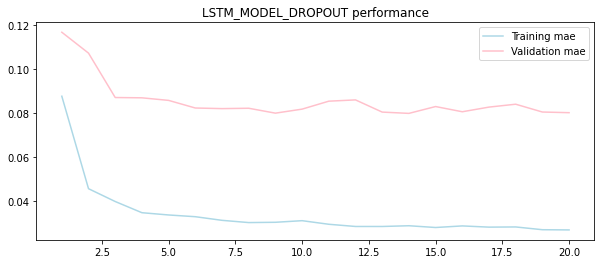

In [155]:
plot_models_comparison(history_rnn_model_dropout, history_lstm_model_dropout, "RNN_MODEL_DROPOUT", "LSTM_MODEL_DROPOUT")